In [1]:
DOC_PATH= 'hostory_book_230p.txt'

# Define the minimum number of sentences per paragraph
MIN_SENTENCES_PER_PARAGRAPH = 3

# Read the content from the file
with open(DOC_PATH, 'r') as file:
    content = file.read()

# Split the content into sentences
sentences = content.split(".")

# Remove any empty strings from the list of sentences
sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

# Group sentences into paragraphs with the minimum number of sentences
paragraphs = []
current_paragraph = []

for sentence in sentences:
    current_paragraph.append(sentence)
    if len(current_paragraph) >= MIN_SENTENCES_PER_PARAGRAPH:
        paragraphs.append(". ".join(current_paragraph) + ".")
        current_paragraph = []

# Add any remaining sentences as a final paragraph
if current_paragraph:
    paragraphs.append(". ".join(current_paragraph) + ".")
    
sentences = paragraphs


In [2]:
import numpy as np 
print(sentences)


['History Of Ancient\nCivilization\n\n by\nCharles Seignobos\nHistory Of Ancient Civilization\nCHAPTER I\nTHE ORIGINS OF CIVILIZATION\nPREHISTORIC ARCHÃ†OLOGY\nPrehistoric Remains. â€”One often finds buried in the earth, weapons,\nimplements, human skeletons, dÃ©bris of every kind left by men of whom\nwe have no direct knowledge. These are dug up by the thousand in all the\nprovinces of France, in Switzerland, in England, in all Europe; they are\nfound even in Asia and Africa.', 'It is probable that they exist in all parts of\nthe world. These remains are called prehistoric because they are more ancient than\nwritten history. For about fifty years men have been engaged in recovering\nand studying them.', 'Today most museums have a hall, or at least, some\ncases filled with these relics. A museum at Saint-German-en-Laye, near\nParis, is entirely given up to prehistoric remains. In Denmark is a collection\nof more than 30,000 objects.', 'Every day adds to the discoveries as\nexcavations 

In [3]:
import ollama
from tqdm import tqdm
import time
def get_embedding_with_retry(model, prompt, max_retries=5, initial_delay=1):
    retries = 0
    delay = initial_delay
    prefix = "clustering : "
    while retries < max_retries:
        try:
            response = ollama.embeddings(model=model, prompt=prefix + prompt)
            return response["embedding"]
        except ollama.ResponseError as e:
            retries += 1
            print(f"Failed to get embedding. Attempt {retries}/{max_retries}. Error: {e}")
            if retries >= max_retries:
                print(f"Max retries reached for sentence: {prompt}.")
                raise e
            time.sleep(delay)
            delay *= 2  # Exponential backoff

embeddings = []
for sentence in tqdm(sentences, desc="embeddings in progress"):
    try:
        embedding = get_embedding_with_retry(model="nomic-embed-text", prompt=sentence)
        embeddings.append(embedding)
    except Exception as e:
        print(f"Failed to get embedding for sentence: {sentence[:30]}. Skipping. Error: {e}")


embeddings in progress: 100%|██████████| 1647/1647 [00:24<00:00, 66.37it/s]


In [4]:
import numpy as np 
data = []
for i , (sentence , embedding) in enumerate( zip(sentences , embeddings ) ): 
    data.append({
        "rank" : i , 
        "sentence" : sentence ,
        "embedding" : np.array(embedding)
    })

print(data[0])

{'rank': 0, 'sentence': 'History Of Ancient\nCivilization\n\n by\nCharles Seignobos\nHistory Of Ancient Civilization\nCHAPTER I\nTHE ORIGINS OF CIVILIZATION\nPREHISTORIC ARCHÃ†OLOGY\nPrehistoric Remains. â€”One often finds buried in the earth, weapons,\nimplements, human skeletons, dÃ©bris of every kind left by men of whom\nwe have no direct knowledge. These are dug up by the thousand in all the\nprovinces of France, in Switzerland, in England, in all Europe; they are\nfound even in Asia and Africa.', 'embedding': array([ 9.58361626e-01,  1.51385987e+00, -4.13461304e+00, -1.89588463e+00,
        1.26855874e+00,  1.20552671e+00, -2.55913079e-01,  2.22902417e-01,
        5.58615327e-01,  2.83640563e-01, -5.02011657e-01, -3.93618435e-01,
        1.87645268e+00,  5.29595792e-01,  7.52965808e-01, -1.94265056e+00,
       -5.84510505e-01,  8.84299994e-01,  5.61858714e-01,  1.44290626e+00,
       -9.01350081e-01,  4.45022881e-02,  1.22075185e-01,  6.34458125e-01,
        1.43420494e+00, -4.707

In [5]:
import numpy as np

def semantic_chunking(data, threshold=0.8):
    chunks = []
    i = 0

    def cosine_similarity(a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

    while i < len(data) - 1:
        a = data[i]["embedding"]
        b = data[i + 1]["embedding"]
        
        # Check for empty embeddings
        if len(a) == 0 or len(b) == 0:
            chunks.append(data[i]["sentence"])
            i += 1
            continue

        sim = cosine_similarity(a, b)
        chunk = data[i]["sentence"]

        while i < len(data) - 2:
            a = data[i]["embedding"]
            b = data[i + 1]["embedding"]

            # Check for empty embeddings
            if len(a) == 0 or len(b) == 0:
                break

            sim = cosine_similarity(a, b)
            if sim < threshold:
                break

            chunk += " " + data[i + 1]["sentence"]
            i += 1

        chunks.append(chunk)
        i += 1

    # If the last sentence hasn't been added, append it as its own chunk
    if i == len(data) - 1:
        chunks.append(data[i]["sentence"])

    return chunks

In [6]:
chunks = semantic_chunking(data , threshold = 0.7)
print( 'Average chunk length in tokens', np.average([len(chunk) for chunk in chunks]))

Average chunk length in tokens 8068.430769230769


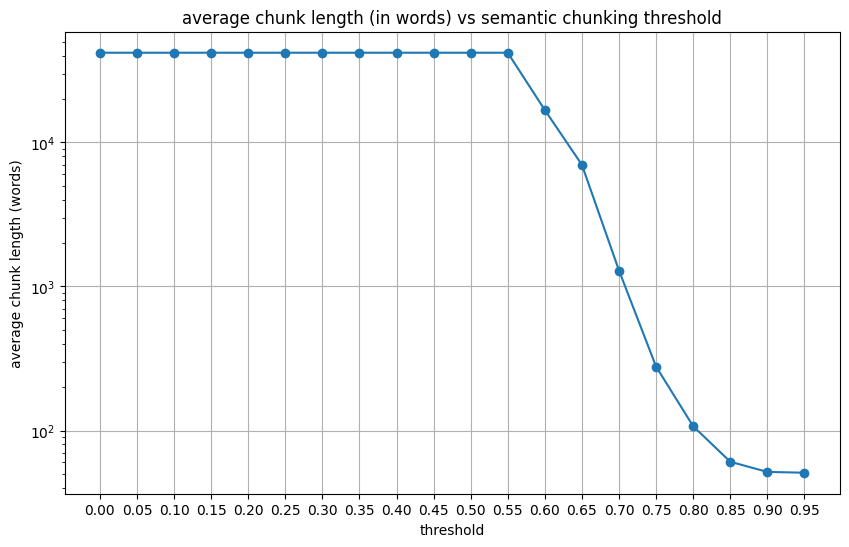

In [7]:
import matplotlib.pyplot as plt 
thresholds = np.arange(0 , 1 , 0.05)
avg_lengths = []
for threshold in thresholds : 
    chunks = semantic_chunking(data , threshold=threshold)
    avg_lengths.append( np.average([len(chunk.split(" ")) for chunk in chunks]))
    
plt.figure(figsize=(10, 6))
plt.plot(thresholds, avg_lengths, marker='o', linestyle='-')
plt.title('average chunk length (in words) vs semantic chunking threshold')
plt.xlabel('threshold')
plt.ylabel('average chunk length (words)')
plt.xticks(thresholds)
plt.grid(True)
plt.yscale('log')
plt.show()


In [8]:
optimal_threshold = 0.7 #about 100 words is good for context 
chunks = semantic_chunking(data = data , threshold=optimal_threshold)

In [9]:
print(len(chunks))

65


In [10]:
model = "nomic-embed-text"
vdb = []
for i , chunk in tqdm(enumerate(chunks) , desc="embedding chunks...") :
    emb = np.array(get_embedding_with_retry(model=model , prompt = chunk )) #embeddings
    if not emb.shape == (0,) : 
        dp = {
            "pos" : i , #chronological position of the chunk 
            "chunk" : chunk , # the chunk itself 
            "embedding" : emb
        }
        vdb.append(dp)


embedding chunks...: 65it [00:07,  9.07it/s]


In [11]:
print(vdb[1])

{'pos': 1, 'chunk': "â€”Man has lived long on the earth, familiar as he was with the mammoth\nand the cave-bear; he lived at least as early as the geological period known\nas the Quaternary. 2. â€”Man has emerged from the savage state to civilized life; he has\ngradually perfected his tools and his ornaments from the awkward axe of\nflint and the necklace of bears' teeth to iron swords and jewels of gold. The\nroughest instruments are the oldest. 3. â€”Man has made more and more rapid progress. Each age has been\nshorter than its predecessor. CHAPTER II\nHISTORY AND THE RECORDS\nHISTORY\nLegends. â€”The most ancient records of people and their doings are\ntransmitted by oral tradition. They are recited long before they are written\ndown and are much mixed with fable. The Greeks told how their heroes of\nthe oldest times had exterminated monsters, fought with giants, and\nbattled against the gods. The Romans had Romulus nourished by a wolf\nand raised to heaven. Almost all peoples relat

In [12]:
print(set([len(d["embedding"]) for d in vdb ]))

{768}


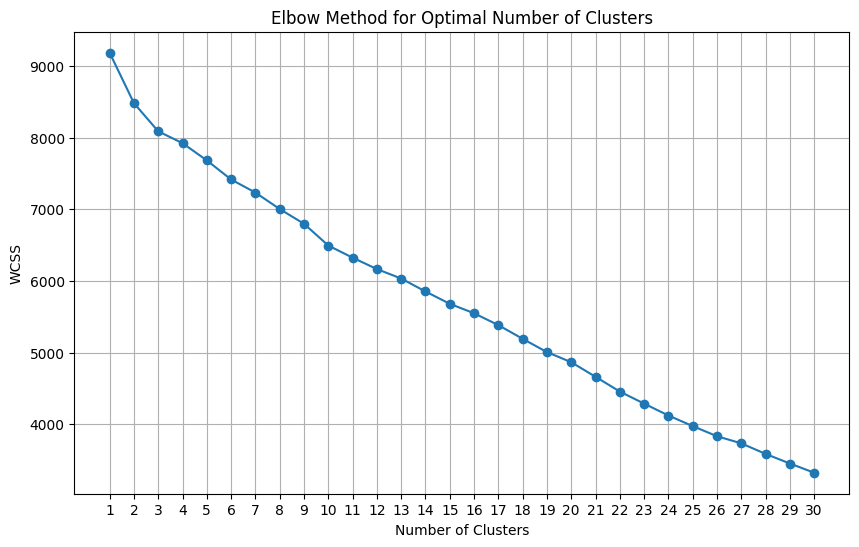

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_wcss(vdb, max_clusters=10):
    """
    Plots the Within-Cluster Sum of Square (WCSS) for different numbers of clusters to determine the optimal number of clusters using the elbow method.

    Parameters:
    - embeddings_dict (dict): Dictionary containing embeddings with keys as identifiers.
    - max_clusters (int): The maximum number of clusters to test. Default is 10.

    Returns:
    - None: Displays a plot of WCSS vs. number of clusters.
    """
    # Convert embeddings to a numpy array
    embeddings = np.array([d["embedding"] for d in vdb ])

    wcss = []

    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)

    # Plot the WCSS
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.xticks(range(1, max_clusters + 1))
    plt.grid(True)
    plt.show()
    
plot_wcss(vdb , max_clusters=30)

In [14]:
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
def cluster_chunks_kmeans(vdb, num_clusters):
    """
    Clusters the embeddings using k-means++.

    Parameters:
    - embeddings_dict (dict): Dictionary containing embeddings with keys as identifiers.
    - num_clusters (int): Number of clusters.

    Returns:
    - dict: A dictionary with the same keys but with cluster labels as values.
    """
    # Convert embeddings to a numpy array
    
    embeddings = np.array([d["embedding"] for d in vdb ])

    # Perform k-means++ clustering
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
    kmeans.fit(embeddings)
    cluster_labels = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_
    # Create a dictionary with conversation IDs and their corresponding cluster labels
    clustered_chunks = [
            { 
                'cluster' : cluster_labels[i] , 
                'chunk' : data_point["chunk"] , 
                'embedding' : data_point['embedding'] ,
                'pos' : data_point["pos"]
            } 
            for i , data_point in enumerate(vdb)
    ]

    return clustered_chunks , cluster_centroids 

In [15]:
num_clusters = 10 
clustered_chunks , cluster_centroids  = cluster_chunks_kmeans(vdb , num_clusters)

In [16]:
clustered_chunks[0]

{'cluster': 3,
 'chunk': "History Of Ancient\nCivilization\n\n by\nCharles Seignobos\nHistory Of Ancient Civilization\nCHAPTER I\nTHE ORIGINS OF CIVILIZATION\nPREHISTORIC ARCHÃ†OLOGY\nPrehistoric Remains. â€”One often finds buried in the earth, weapons,\nimplements, human skeletons, dÃ©bris of every kind left by men of whom\nwe have no direct knowledge. These are dug up by the thousand in all the\nprovinces of France, in Switzerland, in England, in all Europe; they are\nfound even in Asia and Africa. It is probable that they exist in all parts of\nthe world. These remains are called prehistoric because they are more ancient than\nwritten history. For about fifty years men have been engaged in recovering\nand studying them. Today most museums have a hall, or at least, some\ncases filled with these relics. A museum at Saint-German-en-Laye, near\nParis, is entirely given up to prehistoric remains. In Denmark is a collection\nof more than 30,000 objects. Every day adds to the discoveries a

In [17]:
import numpy as np 
def find_closest_data_points_to_centroid(clustered_chunks , cluster_centroids , top_k  ) : 
    closest_sentences = {}
    for cluster_index , cluster_centroid in enumerate( cluster_centroids) :
        distances = []
        for data in clustered_chunks : 
            if data["cluster"] == cluster_index : 
                distances.append({
                    "distance" :np.linalg.norm(cluster_centroid - data["embedding"]) , 
                    "chunk" : data["chunk"]
                })
        
        distances = sorted(distances , key=lambda  x : x["distance"])
        closest_sentences[cluster_index] =[ e["chunk"] for e in distances[ : top_k]]
        
    
    return closest_sentences


closest_chunks = find_closest_data_points_to_centroid(clustered_chunks , cluster_centroids , top_k = 30)
print(closest_chunks[6])
print(f"average length : {np.average([len(d) for d in closest_chunks.values()])}")               

['The Sea. â€”Greece is a land of shores: smaller than Portugal, it has as great a\ncoast-line as Spain. The sea penetrates it to a great number of gulfs, coves,\nand indentations; it is ordinarily surrounded with projecting rocks, or with\napproaching islands that form a natural port. This sea is like a lake; it has\nnot, like the ocean, a pale and sombre color; usually it is calm, lustrous,\nand, as Homer says, "of the color of violets. "\nNo sea lends itself better to navigation with small ships. Every morning the\nnorth wind rises to conduct the barques of Athens to Asia; in the evening\nthe south wind brings them back to port. From Greece to Asia Minor the\nislands are placed like stepping-stones; on a clear day the mariner always\nhas land in view. Such a sea beckons people to cross it. And so the Greeks have been sailors, traders, travellers, pirates, and\nadventurers; like the PhÅ“nicians, they have spread over all the ancient\nworld, carrying with them the merchandise and the 

In [18]:
from openai import OpenAI
import time
import json
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

client = OpenAI(base_url='http://localhost:11434/v1', api_key="ollama")
model = "llama3"

def get_completion_response(messages):
    response = client.chat.completions.create(
        messages=messages,
        model=model,
        temperature=0,
    )
    try:
        return json.loads(response.choices[0].message.content)
    except Exception as e:
        logging.error(f"Error occurred in json.loads: {e}, with output being {response.choices[0].message.content}")
        return response.choices[0].message.content

def aggregate_summaries(closest_chunks, sys_prompt_content):
    aggregated_messages = [{"role": "system", "content": sys_prompt_content}]
    cluster_summaries = {}

    for cluster_index, sentences in closest_chunks.items():
        chunks = " \n -".join(sentences)
        format = """{ 'summary' : 'your outpur goes directly here'}"""
        prompt = "You are an AI assistant designed to summarize text. You will be provided with multiple sentences extracted from a large document that may be incomplete or incoherent  at first sight , you need to focus and try to extract the hidden main ideas . Your task is to summarize these sentences into a coherent single paragraph that captures the main ideas. The sentences are: {chunks} \n you answer in this format {format}, you only output the needed format no more no less please.".format(format=format , chunks=chunks)

        messages = aggregated_messages + [{"role": "user", "content": prompt}]
        summary = get_completion_response(messages)
        
        try:
            summary_text = summary["summary"]
        except Exception as e :
            logging.error(f"Key error occurred: {summary}")
            summary_text = str(summary)
        
        cluster_summaries[cluster_index] = summary_text
        aggregated_messages.append({"role": "assistant", "content": summary_text})

    return cluster_summaries

# Example usage
sys_prompt = "You are an AI assistant designed to summarize text. To give you some context , the document starts this way  : " + "".join(chunks[:10])


cluster_summaries = aggregate_summaries(closest_chunks, sys_prompt)
print(cluster_summaries)


2024-08-04 02:24:11,652 - INFO - HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"
2024-08-04 02:24:11,655 - ERROR - Error occurred in json.loads: Expecting property name enclosed in double quotes: line 1 column 2 (char 1), with output being {'summary': The Spartans were known for their discipline, with warriors living in barracks and engaging in war until they were 60 years old. They had a strict code of conduct, including a focus on physical training and a lack of personal freedom. Despite this, they were proud and laconic, speaking in short phrases. Their country was harsh and unforgiving, with extreme temperatures and violent winds, but also fertile valleys along the rivers where fruits and pastures thrived.
2024-08-04 02:24:11,656 - ERROR - Key error occurred: {'summary': The Spartans were known for their discipline, with warriors living in barracks and engaging in war until they were 60 years old. They had a strict code of conduct, including a focus 

{0: "{'summary': The Spartans were known for their discipline, with warriors living in barracks and engaging in war until they were 60 years old. They had a strict code of conduct, including a focus on physical training and a lack of personal freedom. Despite this, they were proud and laconic, speaking in short phrases. Their country was harsh and unforgiving, with extreme temperatures and violent winds, but also fertile valleys along the rivers where fruits and pastures thrived.", 1: "{'summary': 'The Roman Empire was founded after a century of civil wars and revolutions, with the government of the Senate giving way to the government of generals. The Gracchi brothers attempted to take power from the nobles, but ultimately failed. The need for peace led to the rise of Octavian, who became emperor without having the title, bringing an end to the civil wars and establishing a strong central authority.'}", 2: "{'summary': 'The Assyrian Empire was known for its brutal tactics, including cu

In [19]:
def create_transition_matrix(processed_data , n_clusters) : 
    transition_matrix = np.zeros(shape = (n_clusters ,n_clusters))
    for i in tqdm(range(len(processed_data)-1)) : 
        from_cluster = processed_data[i]["cluster"]
        to_cluster = processed_data[i+1]["cluster"]
        transition_matrix[from_cluster][to_cluster] +=1 

    sum = np.sum(transition_matrix , axis = 1 , keepdims=True)

    return transition_matrix/sum

transition_matrix = create_transition_matrix(clustered_chunks  ,  n_clusters=num_clusters)
print(transition_matrix)

100%|██████████| 64/64 [00:00<00:00, 63310.25it/s]

[[0.14285714 0.         0.14285714 0.         0.28571429 0.28571429
  0.         0.14285714 0.         0.        ]
 [0.09090909 0.63636364 0.         0.09090909 0.         0.
  0.         0.         0.09090909 0.09090909]
 [0.         0.11111111 0.55555556 0.11111111 0.11111111 0.11111111
  0.         0.         0.         0.        ]
 [0.16666667 0.33333333 0.16666667 0.         0.         0.16666667
  0.         0.16666667 0.         0.        ]
 [0.1        0.         0.1        0.1        0.3        0.4
  0.         0.         0.         0.        ]
 [0.18181818 0.09090909 0.09090909 0.         0.18181818 0.18181818
  0.09090909 0.09090909 0.09090909 0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.25       0.         0.25
  0.         0.         0.5        0.        ]
 [0.25       0.         0.         0.         0.25       0.
  0.         0.5        0.         0.        ]
 [

In [20]:
import numpy as np
import networkx as nx
from typing import Dict
import os 
from pyvis.network import Network
import networkx as nx
from pyvis.network import Network
import networkx as nx


def create_directed_graph(transition_matrix, summary_by_cluster):
    G = nx.DiGraph()
    cluster_by_intent = {intent : int(cluster) for cluster , intent in summary_by_cluster.items()}
    # Add edges with weights greater than the specified minimum weight
    for i , from_intent in summary_by_cluster.items():
        for j, to_intent in summary_by_cluster.items():
            #if i != j :
            G.add_edge(from_intent, to_intent, weight=transition_matrix[int(i), int(j)])
    return G 

graph = create_directed_graph(transition_matrix , cluster_summaries)

In [21]:
def plot_graph(G, summary_by_cluster):
    # Define the layout for the graph
    pos = nx.spring_layout(G , iterations=5 , seed=3)
    for k, v in pos.items():
        pos[k] = (-v[0], v[1])  # Flip the x-coordinates to make the graph right to left

    # Draw the nodes with labels
    plt.figure(figsize=(40, 20))
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

    # Draw the edges with customized appearance
    edges = G.edges(data=True)
    nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=50, edge_color='gray', width=4 , arrows=True)
    
    # Draw the edge labels with weights
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=10 , )

    plt.title('Intent Transition Graph')
    plt.axis('off')
    plt.show()
    return G 


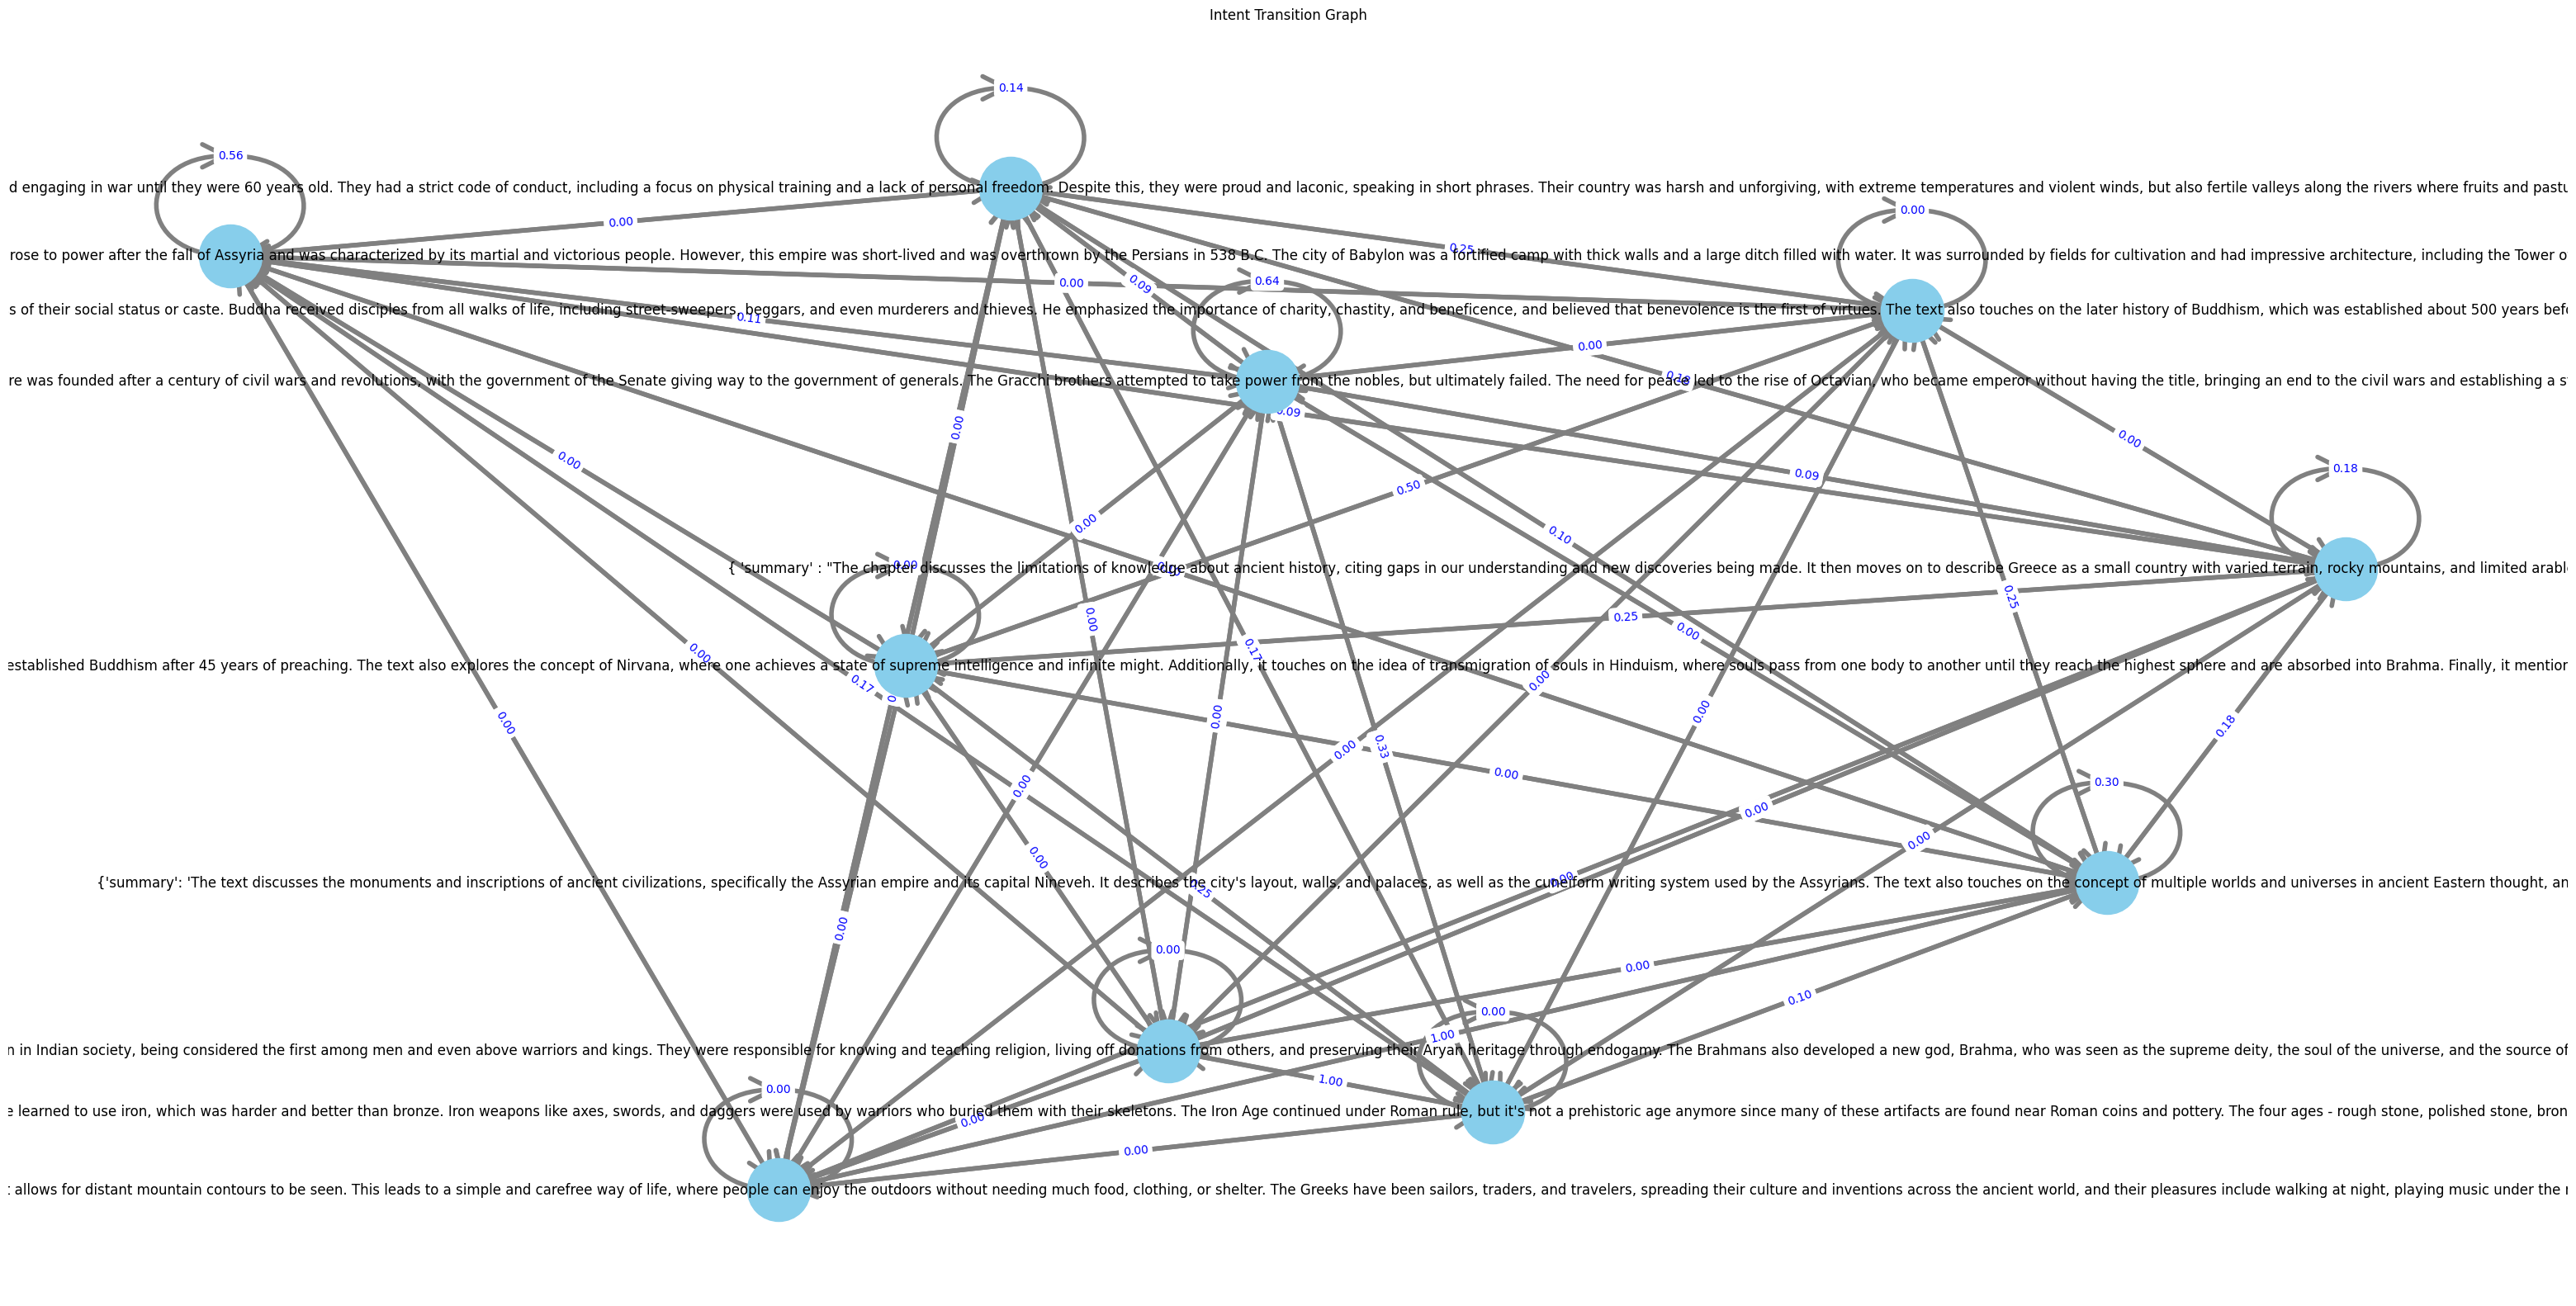

In [22]:
plot_graph(graph  , cluster_summaries)

In [23]:

def most_probable_path(graph, start, end):
    n = len(graph.nodes)
    
    node_to_index = {node: i for i, node in enumerate(graph.nodes)}
    index_to_node = {i: node for node, i in node_to_index.items()}
    
    dp = [[float('inf')] * n for _ in range(1 << n)]
    parent = [[-1] * n for _ in range(1 << n)]
    
    dp[1 << node_to_index[start]][node_to_index[start]] = 0
    
    for mask in range(1 << n):
        for u in range(n):
            if mask & (1 << u):
                for v in range(n):
                    if not mask & (1 << v) and graph.has_edge(index_to_node[u], index_to_node[v]):
                        new_mask = mask | (1 << v)
                        weight = graph[index_to_node[u]][index_to_node[v]].get('weight', 1)
                        if dp[mask][u] + weight < dp[new_mask][v]:
                            dp[new_mask][v] = dp[mask][u] + weight
                            parent[new_mask][v] = u
    
    full_mask = (1 << n) - 1
    u = node_to_index[end]
    min_cost = float('inf')
    end_node = -1

    for i in range(n):
        if dp[full_mask][i] < min_cost and graph.has_edge(index_to_node[i], end):
            min_cost = dp[full_mask][i]
            end_node = i

    if end_node == -1:
        return []

    path = [end]
    mask = full_mask
    u = end_node

    while u != -1:
        path.append(index_to_node[u])
        next_u = parent[mask][u]
        mask ^= (1 << u)
        u = next_u

    path.reverse()
    return path


first_node = cluster_summaries[clustered_chunks[0]["cluster"]]
last_node = cluster_summaries[clustered_chunks[len(clustered_chunks)-1]["cluster"]]
path = most_probable_path(graph , first_node , last_node)

for node in path : 
    print(node)

{'summary': 'The Iron Age began when people learned to use iron, which was harder and better than bronze. Iron weapons like axes, swords, and daggers were used by warriors who buried them with their skeletons. The Iron Age continued under Roman rule, but it's not a prehistoric age anymore since many of these artifacts are found near Roman coins and pottery. The four ages - rough stone, polished stone, bronze, and iron - don't mark periods in humanity's life, but rather epochs in the civilization of each country.'}
{'summary': 'The text describes Buddha's teachings on love, fraternity, and tolerance. He preached to his disciples that they should love even those who do them ill, and that all men are equal regardless of their social status or caste. Buddha received disciples from all walks of life, including street-sweepers, beggars, and even murderers and thieves. He emphasized the importance of charity, chastity, and beneficence, and believed that benevolence is the first of virtues. Th

In [ ]:
messages = [{'role': 'system', 'content': 'You are an advanced summarization assistant.I will provide you with several summaries of important sections of a long document. Your task is to generate a concise and comprehensive summary of the entire document based on these individual summaries.'}]

for summary in path:
    messages.append({'role': 'user', 'content': summary})

messages.append({"role" : "user" , 'content' : """Please analyze these summaries and provide an overall summary of the document. Your summary should capture the main themes, key points, and any significant details from the provided summaries.
summary : """})

overall_summary = get_completion_response(messages)


In [26]:
print(overall_summary)

Based on the provided summaries, here is a comprehensive summary of the document:

The document explores various topics, including ancient history, philosophy, spirituality, and cultural traditions. It begins by discussing the Iron Age, which marked a significant period in human civilization, and how it was characterized by the use of iron tools and weapons.

The text then delves into Eastern spiritual traditions, specifically Buddhism, which emphasizes love, fraternity, tolerance, and charity. It also touches on the concept of Nirvana, where one achieves a state of supreme intelligence and infinite might. Additionally, it explores the idea of transmigration of souls in Hinduism, where souls pass from one body to another until they reach the highest sphere.

The document also discusses Western philosophical traditions, highlighting the lives and teachings of influential figures such as Socrates, Plato, and Aristotle. It also touches on the concept of multiple worlds and universes in an